In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math
from sklearn.metrics import mean_squared_error
from numpy import array

In [2]:
df=pd.read_csv('yahooScrapping/MSFT.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,58.68750,59.3125,56.00000,58.28125,36.065586,53228400
1,2000-01-04,56.78125,58.5625,56.12500,56.31250,34.847267,54119000
2,2000-01-05,55.56250,58.1875,54.68750,56.90625,35.214695,64059600
3,2000-01-06,56.09375,56.9375,54.18750,55.00000,34.035069,54976600
4,2000-01-07,54.31250,56.1250,53.65625,55.71875,34.479828,62013600


In [4]:
df2=df.reset_index()['Close']

In [5]:
df2

0        58.281250
1        56.312500
2        56.906250
3        55.000000
4        55.718750
           ...    
6114    407.570007
6115    409.059998
6116    399.040009
6117    406.320007
6118    402.250000
Name: Close, Length: 6119, dtype: float64

In [6]:
df2.shape

(6119,)

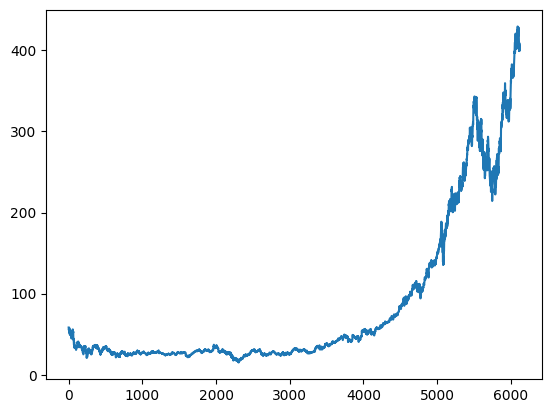

In [7]:
plt.plot(df2)

## Feature Engineering: Scaling Feature down to 0 and 1

In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))

In [9]:
df2

array([[0.10412643],
       [0.09937352],
       [0.10080694],
       ...,
       [0.92677807],
       [0.94435327],
       [0.93452756]])

In [10]:
print(df2)

[[0.10412643]
 [0.09937352]
 [0.10080694]
 ...
 [0.92677807]
 [0.94435327]
 [0.93452756]]


## Train Test Split

#### Time series data split -> Train = 120, 130, 125, 140   Test = 154, 195, 154

In [11]:
training_size=int(len(df2)*0.65)
test_size=len(df2)-training_size
train_data, test_data=df2[0:training_size,:], df2[training_size:len(df2),:1]

In [12]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
training_size, test_size

(3977, 2142)

In [14]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

#### Reshaping dataset to fit LSTM

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Creating LSTM Model

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
# keras.callbacks.ModelCheckpoint
# keras.callbacks.EarlyStopping
# keras.callbacks.LearningRateScheduler
# keras.callbacks.ReduceLROnPlateau
# keras.callbacks.CSVLogger


#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64,verbose=1)

callbacks_list = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
    ),
    ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

model.fit(X_train, y_train, callbacks=callbacks_list, validation_data=(X_test, y_test), epochs=15, batch_size=64,verbose=1)

Epoch 1/15
61/61 [==============================] - 156s 2s/step - loss: 1.5269e-04 - val_loss: 0.0085
Epoch 2/15
61/61 [==============================] - 5s 87ms/step - loss: 1.3601e-05 - val_loss: 0.0035
Epoch 3/15
61/61 [==============================] - 6s 107ms/step - loss: 1.2279e-05 - val_loss: 0.0016
Epoch 4/15
61/61 [==============================] - 5s 84ms/step - loss: 1.2213e-05 - val_loss: 0.0015
Epoch 5/15
61/61 [==============================] - 5s 90ms/step - loss: 1.1249e-05 - val_loss: 7.3090e-04
Epoch 6/15
61/61 [==============================] - 5s 88ms/step - loss: 9.8693e-06 - val_loss: 5.3214e-04
Epoch 7/15
61/61 [==============================] - 5s 87ms/step - loss: 1.0294e-05 - val_loss: 4.3925e-04
Epoch 8/15
61/61 [==============================] - 5s 88ms/step - loss: 8.7581e-06 - val_loss: 3.2605e-04
Epoch 9/15
61/61 [==============================] - 5s 85ms/step - loss: 9.2109e-06 - val_loss: 3.4304e-04
Epoch 10/15
61/61 [==============================] -

## Prediction

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

64/64 [==============================] - 2s 31ms/step


#### transform back to original data form

In [20]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
math.sqrt(mean_squared_error(y_train, train_predict))

30.194516171104134

#### Test Data RMSE

In [22]:
math.sqrt(mean_squared_error(y_test, test_predict))

218.0106336646343

### Plotting Predictions

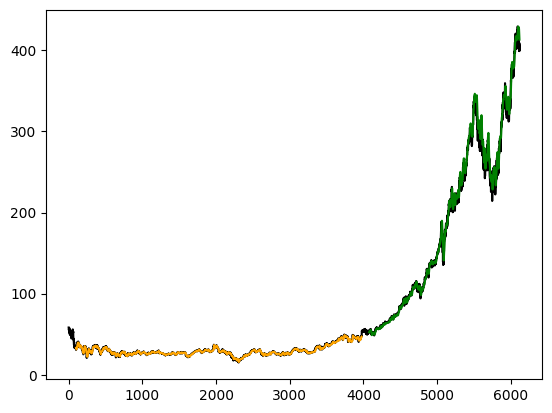

In [23]:
look_back=100
trainPredictPlot=np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#shift test prediction for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict

#plot baseline and predictions
plt.plot(scaler.inverse_transform(df2), color='black')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

## Prediction for the next 30 days

In [24]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 1801)

In [25]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [26]:
lst_output=[]
n_steps=1800
i=0
while(i<30):
    
    if(len(temp_input)>1800):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.11858432 0.11889818 0.12032253 ... 0.92677807 0.94435327 0.93452756]
0 day output [[0.95374125]]
1 day input [0.11889818 0.12032253 0.11969486 ... 0.94435327 0.93452756 0.95374125]
1 day output [[0.95184946]]
2 day input [0.12032253 0.11969486 0.12017769 ... 0.93452756 0.95374125 0.95184946]
2 day output [[0.95127183]]
3 day input [0.11969486 0.12017769 0.11964656 ... 0.95374125 0.95184946 0.95127183]
3 day output [[0.95178354]]
4 day input [0.12017769 0.11964656 0.11892232 ... 0.95184946 0.95127183 0.95178354]
4 day output [[0.9531013]]
5 day input [0.11964656 0.11892232 0.11974313 ... 0.95127183 0.95178354 0.95310128]
5 day output [[0.9549653]]
6 day input [0.11892232 0.11974313 0.11947757 ... 0.95178354 0.95310128 0.95496529]
6 day output [[0.95717186]]
7 day input [0.11974313 0.11947757 0.12003284 ... 0.95310128 0.95496529 0.95717186]
7 day output [[0.9595766]]
8 day input [0.11947757 0.12003284 0.12017769 ... 0.95496529 0.95717186 0.95957661]
8 day output [[0.962085

In [27]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [28]:
len(df2)

6119

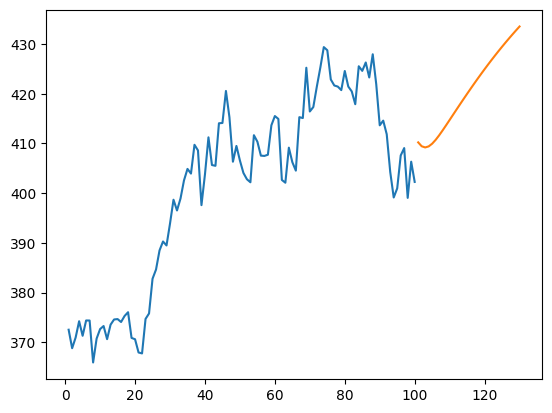

In [29]:
plt.plot(day_new,scaler.inverse_transform(df2[6019:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

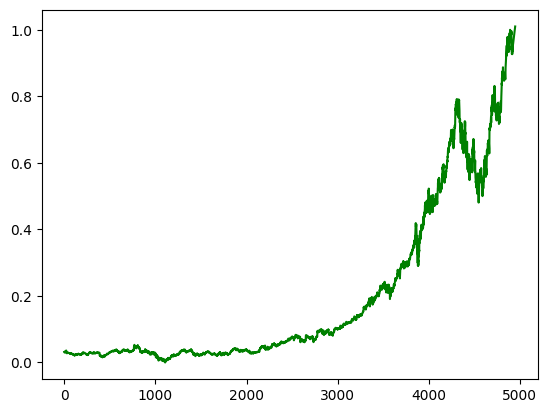

In [30]:
df3=df2.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:], color='green')

In [31]:
df3=scaler.inverse_transform(df3).tolist()

In [32]:
df2.size

6119

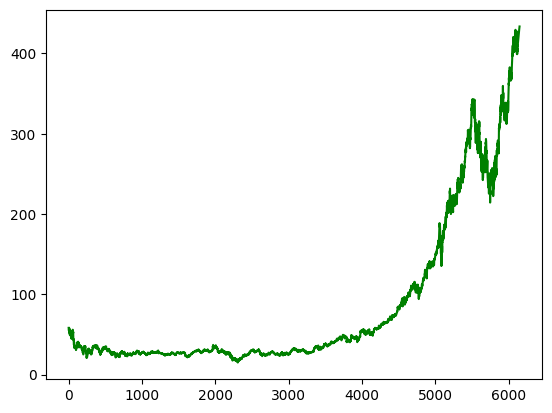

In [33]:
plt.plot(df3, color='green')